### Test 1
## Texto-to-3D: point cloud reconstruction from synthetic images
In this notebook we use a pre-trained model, [Stable Diffusion 2](https://huggingface.co/stabilityai/stable-diffusion-2) (based on [Rombach et al. 2022](https://arxiv.org/abs/2112.10752)), to generate synthetic images from a text prompt.

<img src="/img/stable_pointe.png" alt= "Stable-Point-E Pipeline" width="700px">

More precisely: 
- Stable Diffusion 2 is used to inpaint an imagined object inside a "white booth" to prevent shadows, background or undesired objects to appear in the image and cause artifacts in the reconstructed point cloud. 
- For point-cloud reconstruction, [Point-E (Nichol et al. 2022)](https://arxiv.org/abs/2212.08751) pre-trained on 300M and 1B training samples is used. It consists in a point-cloud [diffusion model](https://halixness.github.io/2023/intro-to-diffusion/), that is a generative model that given a random noise point cloud, it learns to denoise this into an object point cloud given some conditioning signal (e.g. image, text). Ideally, Point-E learns a distribution of 3d objects (e.g. a dataset) and you can sample from it by guiding a random point in the distribution with text/images.

In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

In [2]:
# Initial parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 512
border = 100
background_color = 255

**Text-to-image synthesis with Stable Diffusion 2**

In [3]:
# Creating a "booth": a white canvas with a central black square to replace with inpainting.
booth = np.ones((img_size, img_size,3))*background_color
booth[border:img_size-border,border:img_size-border,:] = 0
booth = Image.fromarray(booth.astype(np.uint8()))

# Creating the image mask for inpainting
mask = np.zeros((img_size,img_size,3))
mask[border:img_size-border,border:img_size-border,:] = 255
mask = Image.fromarray(mask.astype(np.uint8()))

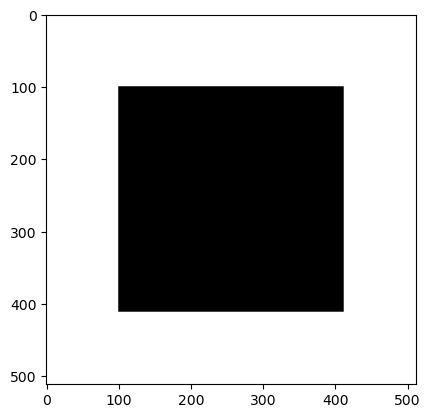

In [4]:
plt.imshow(booth)

In [4]:
# Loading pre-trained SD2 from HuggingFace
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

text_encoder\model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [5]:
# Attempting to generate multiple views with prompt engineering
generated_images = []
prompt = "a hamburger"
views = ["left", "bottom", "frontal", "top"]
num_views = len(views)

for i in range(num_views):
    prompt_details = ", full body" + views[i] + " camera view, blender render, high resolution, standard light, no reflections"
    generated_images.append(pipe(prompt=prompt + prompt_details, image=booth, mask_image=mask).images[0])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

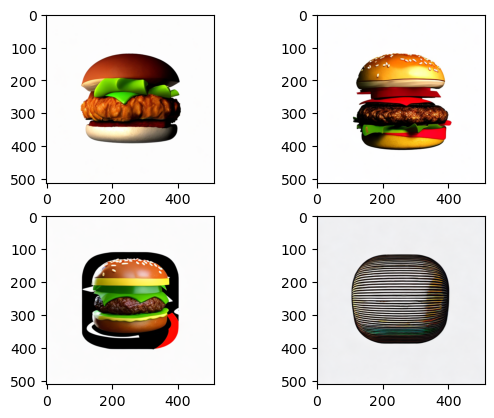

In [6]:
# Generated views have semantic differences
cols = 2
rows = (num_views // cols)
f, axarr = plt.subplots(rows, cols)
for i in range(num_views):
    axarr[i // cols, i % cols].imshow(generated_images[i])

### Point cloud generation with POINT-E

In this project, we have modified the architecture of POINT-E in order to accept multiple views:

<img src="img/modified_pointe.png" alt= "Modified Point-E Denoiser" width="450px">

- Each view is encoded with the [CLIP (Radford et al. 2021)](https://arxiv.org/abs/2103.00020) image encoder, leading to a matrix of image patches. Such patches, or "tokens", are concatenated and fed to the denoising transformer in POINT-E to condition the point cloud denoising process.

In [7]:
# Saving GPU memory
PILtoTensor = transforms.ToTensor()
torch.cuda.empty_cache()
del pipe

In [8]:
from mv_point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from mv_point_e.diffusion.sampler import PointCloudSampler
from mv_point_e.models.download import load_checkpoint
from mv_point_e.models.configs import MODEL_CONFIGS, model_from_config
from mv_point_e.util.plotting import plot_point_cloud

In [9]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

# Instantiating the Point-E model 
# with our changes, by default the number of input views is 4

MODEL_CONFIGS[base_name]["n_views"] = num_views
MODEL_CONFIGS['upsample']["n_views"] = num_views

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [10]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [11]:
# Produce a sample from the model, iterative diffusion process
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=generated_images))):
    samples = x

0it [00:00, ?it/s]

In [12]:
samples.shape

torch.Size([1, 6, 4096])

**Note:** according to the views, only one contained a e.g. a slice of tomato. We can see POINT-E aggregates semantic information to build a consistent 3d object.

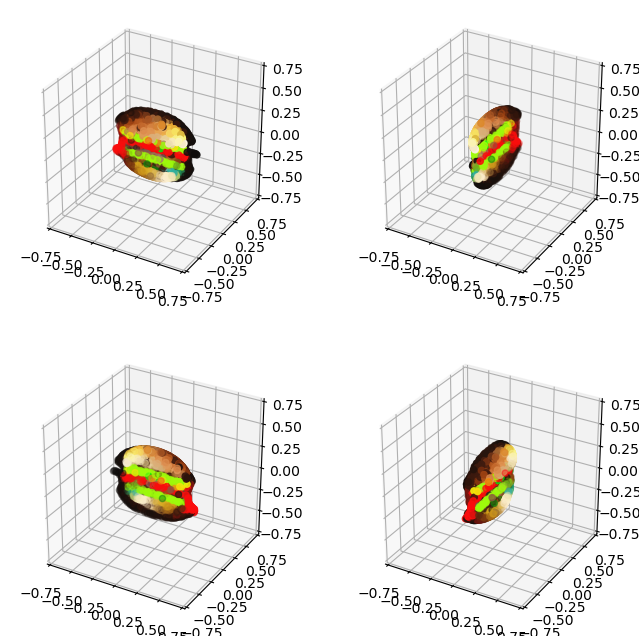

In [13]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

**From point cloud to mesh with Signed Distance Fields**

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from mv_point_e.models.download import load_checkpoint
from mv_point_e.models.configs import MODEL_CONFIGS, model_from_config
from mv_point_e.util.pc_to_mesh import marching_cubes_mesh
from mv_point_e.util.plotting import plot_point_cloud
from mv_point_e.util.point_cloud import PointCloud

In [15]:
# Signed distance field model, pretrained by OpenAI
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [16]:
import skimage.measure
skimage.measure.label

# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/512 [00:00<?, ?it/s]

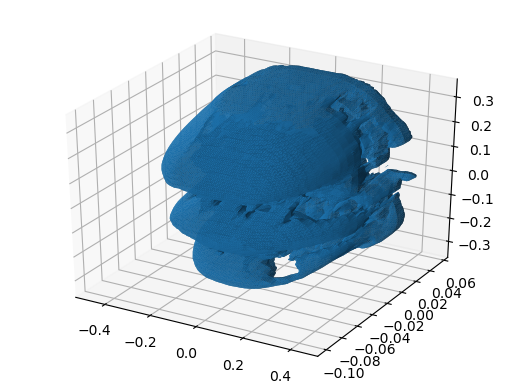

In [17]:
# Write the mesh to a PLY file to import into some other program.
# with open('mesh.ply', 'wb') as f:
#    mesh.write_ply(f)
from mpl_toolkits.mplot3d import Axes3D

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.verts[:, 0], mesh.verts[:,1], triangles=mesh.faces, Z=mesh.verts[:,2]) 
plt.show()